We will compare different types of **combinations of algorithms** for segmentation of Brain Tumor. We will then find out the loss by **Dice Loss Function** of each approach.


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2

%matplotlib inline

DATADIR = "/content/drive/My Drive/Colab_Notebooks/brain_tumor_custom"
CATEGORIES = ["Tumor", "Mask"]

for category in CATEGORIES:
    i = 0
    path = os.path.join(DATADIR, category)  # create path to tumor
    for img in os.listdir(path):  # iterate over each image per tumor
        img_array = cv2.imread(os.path.join(path,img))# ,cv2.IMREAD_GRAYSCALE) # convert to array
        m = cv2.imwrite('/content/drive/My Drive/Colab_Notebooks/brain_tumor_custom/'+category+"_jpg/"+os.listdir(path)[i][:-4]+'.jpg', img_array)
        i+=1
        # plt.imshow(img_array, cmap='gray')  # graph it
        # plt.show()

In [ ]:
from sklearn import preprocessing
# normalized_array = preprocessing.normalize(img_array)

We define **KMeans( ) Funcion**. We take the numpy array image as input. Afyer proprocessing its pixel values, we make segmenation with K = 8. 

In [ ]:
def KMeans(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = image.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 8
    ret,labels,(centers)=cv2.kmeans(pixel_values,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    # convert back to 8 bit values
    centers = np.uint8(centers)

    # flatten the labels array
    labels = labels.flatten()

    # convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]

    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(image.shape)
    
    # disable only the clusters(turn the pixel into black)
    # masked_image = np.copy(image)
    # # convert to the shape of a vector of pixel values
    # masked_image = masked_image.reshape((-1, 3))
    # # color (i.e cluster) to disable
    # for i in range(0, 7):
    #     if i==1:
    #         continue
    #     cluster = i
    #     masked_image[labels == cluster] = [0, 0, 0]
    # # convert back to original shape
    # masked_image = masked_image.reshape(image.shape)
    # # plt.imshow(masked_image, 'gray')

    # plt.show()
    return segmented_image



We define morphology( ) Funcion. We take the numpy array image as input. We do some steps here:<br>
*   Remove Salt and Pepper noise
*   Median Filtering

*   Sobl Filtering
*   Taking a threshold of 80

*   Some morphological Operations(Erosion, Dilation, Opening & Closing)










In [ ]:
def morphology1(image):
    # Remove Salt and Pepper noise
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    # gray = image
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    median_filter = cv2.medianBlur(gray, 5)
    # plt.imshow(median_filter, 'gray')

    #Edge
    # 3*3 Sobel Filters
    Gx= np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    # print ("Gx \n", Gx)
    Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    # print ("Gy \n", Gy)
    img_sobelx = cv2.Sobel(median_filter,cv2.CV_8U,1,0,ksize=3)
    img_sobely = cv2.Sobel(median_filter,cv2.CV_8U,0,1,ksize=3)
    #del f = Gx + Gy
    # Adding mask to the image
    img_sobel = img_sobelx + img_sobely + gray
    # plt.imshow(img_sobel,cmap='gray')
    # plt.show()

    # Threshold.
    # take the mean of the pixel values and use that as a threshold.
    gray_r = gray.reshape(gray.shape[0] * gray.shape[1])
    threshold = 80
    maxValue = 255
    
    # Threshold the pixel values
    th, thresh = cv2.threshold(img_sobel, threshold, maxValue, cv2.THRESH_BINARY)
    # plt.imshow(thresh,cmap='gray')
    # plt.show()

    # remove any small white noises in the image using morphological opening. 
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 6)
    # plt.imshow(opening,cmap='gray')
    # plt.show()

    # Black region shows sure background area
    # Dilation increases object boundary to background.
    sure_bg = cv2.dilate(opening,kernel,iterations=4)
    # plt.imshow(sure_bg,cmap='gray')
    # plt.show()

    # White region shows sure foreground area
    dist_transform = cv2.distanceTransform(sure_bg, cv2.cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.4*dist_transform.max(),255,0)
    # plt.imshow(sure_fg,cmap='gray')
    # plt.show()

    # #Erosion
    # gray = (gray, 0)
    # kernel = np.ones((3, 3), np.uint8)
    # erosion = cv2.erode(thresh,kernel,iterations = 10)
    # # plt.imshow(erosion, cmap='gray')

    # #Dialation
    # dilate = cv2.erode(erosion,kernel,iterations = 10)
    # # plt.imshow(dilate, cmap='gray')

    #opening, closing
    # opening = cv2.morphologyEx(sure_fg, cv2.MORPH_OPEN, kernel)
    # # plt.imshow(opening, 'gray')
    closing = cv2.morphologyEx(sure_fg, cv2.MORPH_CLOSE, kernel)

    return closing


In [ ]:
def morphology2(image):
    # Remove Salt and Pepper noise
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    # gray = image
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    median_filter = cv2.medianBlur(gray, 5)
    # plt.imshow(median_filter, 'gray')

    #Edge
    # 3*3 Sobel Filters
    Gx= np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    # print ("Gx \n", Gx)
    Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    # print ("Gy \n", Gy)
    img_sobelx = cv2.Sobel(median_filter,cv2.CV_8U,1,0,ksize=3)
    img_sobely = cv2.Sobel(median_filter,cv2.CV_8U,0,1,ksize=3)
    #del f = Gx + Gy
    # Adding mask to the image
    img_sobel = img_sobelx + img_sobely + gray
    # plt.imshow(img_sobel,cmap='gray')
    # plt.show()

    # Threshold.
    # take the mean of the pixel values and use that as a threshold.
    gray_r = gray.reshape(gray.shape[0] * gray.shape[1])
    threshold = 70
    maxValue = 255
    
    # Threshold the pixel values
    th, thresh = cv2.threshold(img_sobel, threshold, maxValue, cv2.THRESH_BINARY)
    # plt.imshow(thresh,cmap='gray')
    # plt.show()

    # remove any small white noises in the image using morphological opening. 
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 0)
    # plt.imshow(opening,cmap='gray')
    # plt.show()

    # Black region shows sure background area
    # Dilation increases object boundary to background.
    sure_bg = cv2.dilate(opening,kernel,iterations=0)
    # plt.imshow(sure_bg,cmap='gray')
    # plt.show()

    # White region shows sure foreground area
    dist_transform = cv2.distanceTransform(sure_bg, cv2.cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.4*dist_transform.max(),255,0)
    closing = cv2.morphologyEx(sure_fg, cv2.MORPH_CLOSE, kernel)

    return closing


We Define **filters( ) Funtion**. We do some filtering like:


*   Bilateral
*   Median

*   GuassianBlur
*   Contours





In [ ]:
def filters(image):
    path = "/content/drive/My Drive/Colab_Notebooks/brain_tumor_custom/o2"

    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    bilateral = cv2.bilateralFilter(gray, 2, 50, 50)
    cv2.imwrite(os.path.join(path, 'bilateral.jpg'), bilateral)

    img = cv2.imread(os.path.join(path, "bilateral.jpg"))
    median = cv2.medianBlur(img, 5)
    cv2.imwrite(os.path.join(path, 'median.jpg'), median)

    img = cv2.imread(os.path.join(path, "median.jpg"))
    equ1 = cv2.GaussianBlur(img, (5, 5), cv2.BORDER_CONSTANT)
    cv2.imwrite(os.path.join(path, 'equ1.jpg'), equ1)

    img = cv2.imread(os.path.join(path, "equ1.jpg"))
    ret, thresh1 =cv2.threshold(img,70,255,cv2.THRESH_BINARY)
    cv2.imwrite(os.path.join(path, 'thresh1.jpg'), thresh1)

    img = cv2.imread(os.path.join(path, "thresh1.jpg"))
    kernel = np.ones((5, 5), np.uint8)
    opening1 = cv2.dilate(img, kernel, iterations=0)
    opening2 = cv2.morphologyEx(opening1, cv2.MORPH_CLOSE, kernel)

    dilated = cv2.imwrite(os.path.join(path, 'dilated.jpg'), opening2)
    
    dilate = cv2.imread(os.path.join(path, "dilated.jpg"))
    grey2 = cv2.cvtColor(dilate, cv2.COLOR_RGB2GRAY)

    contours, hierarchy = cv2.findContours(grey2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    b = cv2.drawContours(gray, contours, -1, (0, 0, 255), 3)

    dst = cv2.addWeighted(grey2, 0.7, b, 0.3, 0)

    cv2.imwrite(os.path.join(path, 'contour.jpg'), dst)
    dilate = cv2.imread(os.path.join(path, "contour.jpg"))

    return dilate



### Now We make some combinations of those functions and see the efficieny.
# Kmeans + Morphology

In [ ]:
CATEGORIES = ["Tumor"]
for category in CATEGORIES:  
    path = os.path.join(DATADIR, category)  # create path to tumor
    i = 0
    for img in os.listdir(path):  # iterate over each image per tumor
        image = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
        

        output_k = KMeans(image)
        output = morphology1(output_k)
        # out = morphology(img)
        # plt.imshow(im)
        m = cv2.imwrite('/content/drive/My Drive/Colab_Notebooks/brain_tumor_custom/Output_km/'+os.listdir(path)[i][:-4]+'_km.jpg', output)
        # plt.imshow(output_k)
        # print(os.path.join(path,img))
        
        i += 1
        # plt.imshow(m, 'gray')

# Filters + Morphology

In [ ]:
CATEGORIES = ["Tumor"]
for category in CATEGORIES:  
    path = os.path.join(DATADIR, category)  # create path to tumor
    i = 0
    for img in os.listdir(path):  # iterate over each image per tumor
        # image = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
        # print(image.shape)

        # output_k = KMeans(image)
        # output = morphology(output_k)
        output_f = filters(cv2.imread(os.path.join(path,img)))
        output = morphology2(output_f)
        # out = morphology(img)
        # plt.imshow(im)
        m = cv2.imwrite('/content/drive/My Drive/Colab_Notebooks/brain_tumor_custom/Output_fm/'+os.listdir(path)[i][:-4]+'_fm.jpg', output)
        # plt.imshow(output_f)
        # print(os.path.join(path,img))
        # plt.imshow(output)
        # print(output.shape)
        # break
        i += 1
        # plt.imshow(m, 'gray')

# Kmeans + Filters + Morphology

In [ ]:
CATEGORIES = ["Tumor"]
for category in CATEGORIES:  
    path = os.path.join(DATADIR, category)  # create path to tumor
    i = 0
    for img in os.listdir(path):  # iterate over each image per tumor
        image = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
        # print(image.shape)

        output_k = KMeans(image)
        output_f = filters(output_k)
        output = morphology1(output_f)
        # out = morphology(img)
        # plt.imshow(im)
        m = cv2.imwrite('/content/drive/My Drive/Colab_Notebooks/brain_tumor_custom/Output_kfm/'+os.listdir(path)[i][:-4]+'_kfm.jpg', output)
        # plt.imshow(output_k)
        # print(os.path.join(path,img))
        # plt.imshow(output)
        # print(output.shape)
        # break
        i += 1
        # plt.imshow(m, 'gray')

# Only Filters


In [ ]:
CATEGORIES = ["Tumor"]
for category in CATEGORIES:  
    path = os.path.join(DATADIR, category)  # create path to tumor
    i = 0
    for img in os.listdir(path):  # iterate over each image per tumor
        image = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        output_f = filters(image)
        # out = morphology(img)
        # plt.imshow(im)
        m = cv2.imwrite('/content/drive/My Drive/Colab_Notebooks/brain_tumor_custom/Output_f/'+os.listdir(path)[i][:-4]+'_f.jpg', output_f)
        i += 1

# Show Results

Tumor_jpg shape: (256, 256, 3)
Mask_jpg shape: (256, 256, 3)
Output_km shape: (256, 256, 3)
Output_fm shape: (256, 256, 3)
Output_kfm shape: (256, 256, 3)
          Tumor                     Original Mask                KMeans+Morphology             Filter+Morphology                  K+F+M      


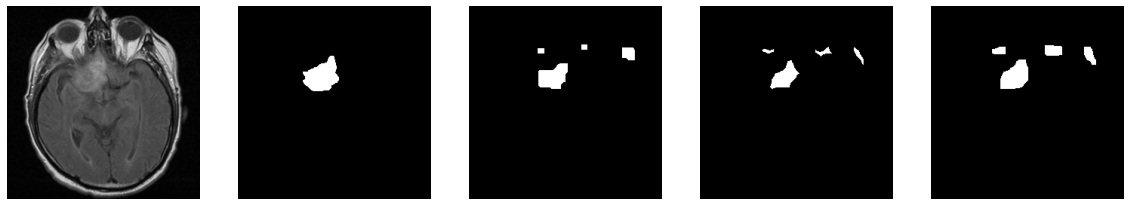

          Tumor                     Original Mask                KMeans+Morphology             Filter+Morphology                  K+F+M      


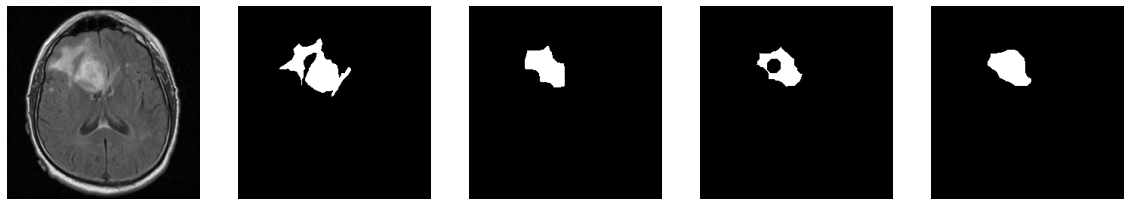

          Tumor                     Original Mask                KMeans+Morphology             Filter+Morphology                  K+F+M      


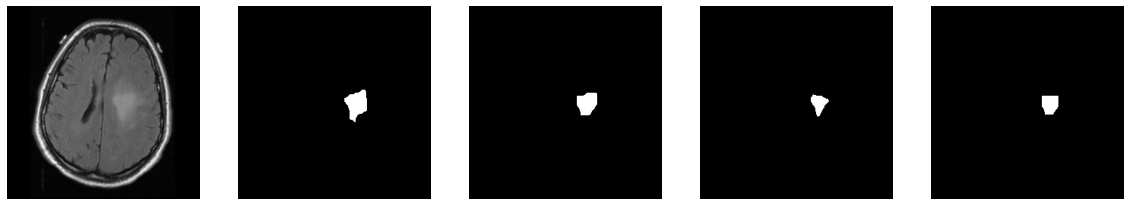

          Tumor                     Original Mask                KMeans+Morphology             Filter+Morphology                  K+F+M      


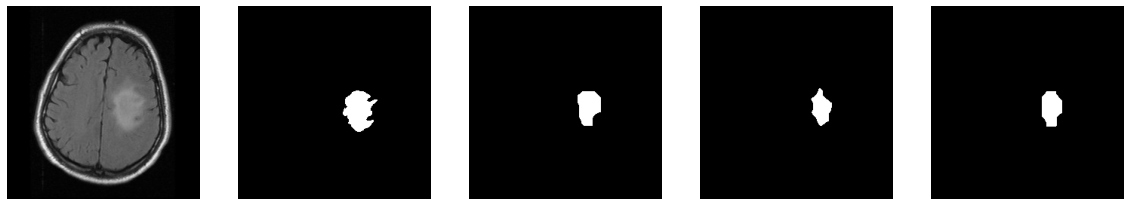

          Tumor                     Original Mask                KMeans+Morphology             Filter+Morphology                  K+F+M      


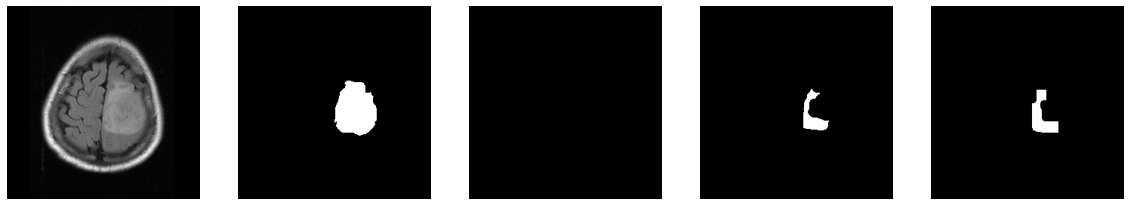

          Tumor                     Original Mask                KMeans+Morphology             Filter+Morphology                  K+F+M      


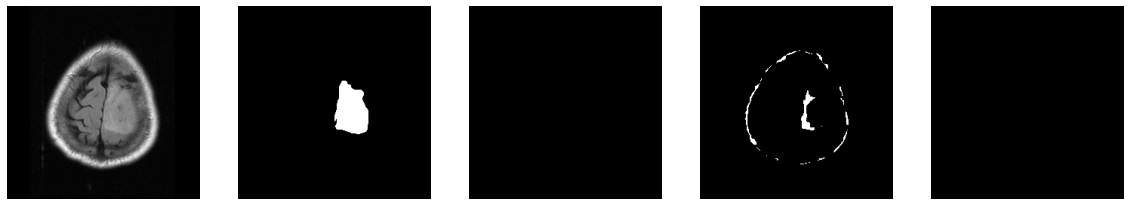

          Tumor                     Original Mask                KMeans+Morphology             Filter+Morphology                  K+F+M      


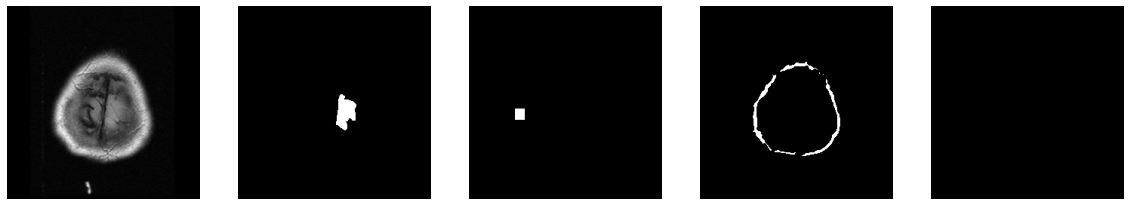

          Tumor                     Original Mask                KMeans+Morphology             Filter+Morphology                  K+F+M      


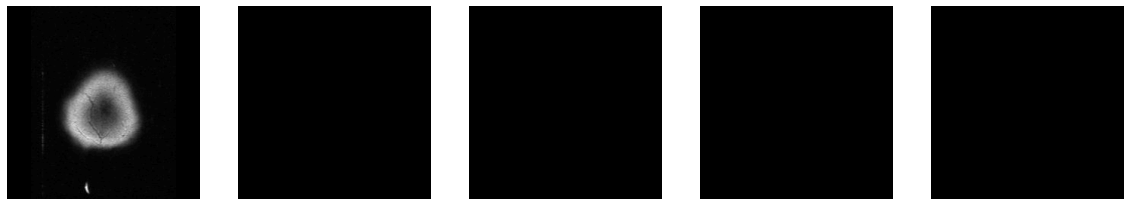

In [ ]:
titles = ['Tumor_jpg', 'Mask_jpg', 'Output_km', 'Output_fm', 'Output_kfm']#, 'Output_f']
for i in range(5):
    print(titles[i] ,"shape:",cv2.imread(os.path.join(path,sorted(os.listdir(path))[i])).shape)
for i in range(8):
    j = 0
    print("          Tumor                     Original Mask                KMeans+Morphology             Filter+Morphology                  K+F+M      ")
    for t in titles:
        path = os.path.join(DATADIR, t)
        if t==titles[0]:
            img0 = cv2.imread(os.path.join(path,sorted(os.listdir(path))[i]) ,cv2.IMREAD_GRAYSCALE)
        elif t==titles[1]:
            img1 = cv2.imread(os.path.join(path,sorted(os.listdir(path))[i]) ,cv2.IMREAD_GRAYSCALE)
        elif t==titles[2]:
            img2 = cv2.imread(os.path.join(path,sorted(os.listdir(path))[i]) ,cv2.IMREAD_GRAYSCALE)
        elif t==titles[3]:
            img3 = cv2.imread(os.path.join(path,sorted(os.listdir(path))[i]) ,cv2.IMREAD_GRAYSCALE)
        elif t==titles[4]:
            img4 = cv2.imread(os.path.join(path,sorted(os.listdir(path))[i]) ,cv2.IMREAD_GRAYSCALE)
        # elif t==titles[5]:
        #     img5 = cv2.imread(os.path.join(path,sorted(os.listdir(path))[i]) ,cv2.IMREAD_GRAYSCALE)
            
            fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(20, 10))
            ax0.imshow(img0, 'gray')
            ax0.axis('off')
            ax1.imshow(img1, 'gray')
            ax1.axis('off')
            ax2.imshow(img2, 'gray')
            ax2.axis('off')
            ax3.imshow(img3, 'gray')
            ax3.axis('off')
            ax4.imshow(img4, 'gray')
            ax4.axis('off')
            # ax5.imshow(img5, 'gray')
            # ax5.axis('off')
        # plt.subplot(2,5,j+1), plt.imshow(img, 'gray') #to plot multiple images
        # plt.title(titles[j])
        # j += 1
        # plt.xticks([]),plt.yticks([])
    plt.show()

# **Evalutation**

We define **Soft Dice Loss Funtion**

In [ ]:
def soft_dice_loss(y_true, y_pred, epsilon=1e-9): 

# Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
# Assumes the `channels_last` format.

# Arguments
    # y_true: b x X x Y( x Z...) x c One hot encoding of ground truth
    # y_pred: b x X x Y( x Z...) x c Network output, must sum to 1 over c channel (such as after softmax) 
    # epsilon: Used for numerical stability to avoid divide by zero errors


# skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * np.sum(y_pred * y_true, axes)
    denominator = np.sum(np.square(y_pred) + np.square(y_true), axes)

    return 1 - np.mean(numerator / (denominator + epsilon))

In [ ]:
#Take data in array
CATEGORIES = ["Mask_jpg", "Output_km", "Output_fm", "Output_kfm"]#, "Output_f"]
mask_jpg_array = []; output_km_array = []; output_fm_array = []; output_kfm_array = [];# output_f_array = []
for category in CATEGORIES:  
    path = os.path.join(DATADIR, category)
    if category == "Mask_jpg":
        for img in sorted(os.listdir(path)):  # iterate over each image per tumor
            image = cv2.imread(os.path.join(path,img))# ,cv2.IMREAD_GRAYSCALE)
            mask_jpg_array.append(image)
    elif category == "Output_km":
        for img in sorted(os.listdir(path)):
            image = cv2.imread(os.path.join(path,img))# ,cv2.IMREAD_GRAYSCALE)
            output_km_array.append(image)
    elif category == "Output_fm":
        for img in sorted(os.listdir(path)):
            image = cv2.imread(os.path.join(path,img))# ,cv2.IMREAD_GRAYSCALE)
            output_fm_array.append(image)
    elif category == "Output_kfm":
        for img in sorted(os.listdir(path)):
            image = cv2.imread(os.path.join(path,img))# ,cv2.IMREAD_GRAYSCALE)
            output_kfm_array.append(image)
    # elif category == "Output_f":
    #     for img in sorted(os.listdir(path)):
    #         image = cv2.imread(os.path.join(path,img))# ,cv2.IMREAD_GRAYSCALE)
    #         output_f_array.append(image)

    # print(mask_jpg_array)

In [ ]:
import tensorflow as tf
mask_jpg_array = tf.convert_to_tensor(
    mask_jpg_array, dtype=None, dtype_hint=None, name=None
)
output_km_array = tf.convert_to_tensor(
    output_km_array, dtype=None, dtype_hint=None, name=None
)
output_fm_array = tf.convert_to_tensor(
    output_fm_array, dtype=None, dtype_hint=None, name=None
)
output_kfm_array = tf.convert_to_tensor(
    output_kfm_array, dtype=None, dtype_hint=None, name=None
)
# output_f_array = tf.convert_to_tensor(
#     output_f_array, dtype=None, dtype_hint=None, name=None
# )


## Loss in Different Approaches

In [ ]:
print("KMeans + Morphology:", soft_dice_loss(mask_jpg_array, output_km_array))
print("Filters + Morphology:", soft_dice_loss(mask_jpg_array, output_fm_array))
print("KMeans + Filters + Morphology:", soft_dice_loss(mask_jpg_array, output_kfm_array))
# print("Only Filters", soft_dice_loss(mask_jpg_array, output_kfm_array))
# print("Mask + Mask", soft_dice_loss(mask_jpg_array, mask_jpg_array))

KMeans + Morphology: 0.7383616072658217
Filters + Morphology: 0.7179956258897653
KMeans + Filters + Morphology: 0.7113896797019694
